In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [2]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [76]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

In [4]:
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


In [18]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[data[variable] >= lower][data[variable] <= upper]

In [80]:
training_data = remove_outliers(training_data, "Sale Price", lower=500)

In [81]:
training_data.shape

(168931, 62)

In [85]:
training_data["Log Sale Price"] = np.log(training_data["Sale Price"])

In [86]:
training_data["Bathrooms"] = training_data["Description"].str.extract(r"([\d\.]+) of which are bathrooms").fillna(0).astype(float)

<AxesSubplot:xlabel='Bathrooms', ylabel='Log Sale Price'>

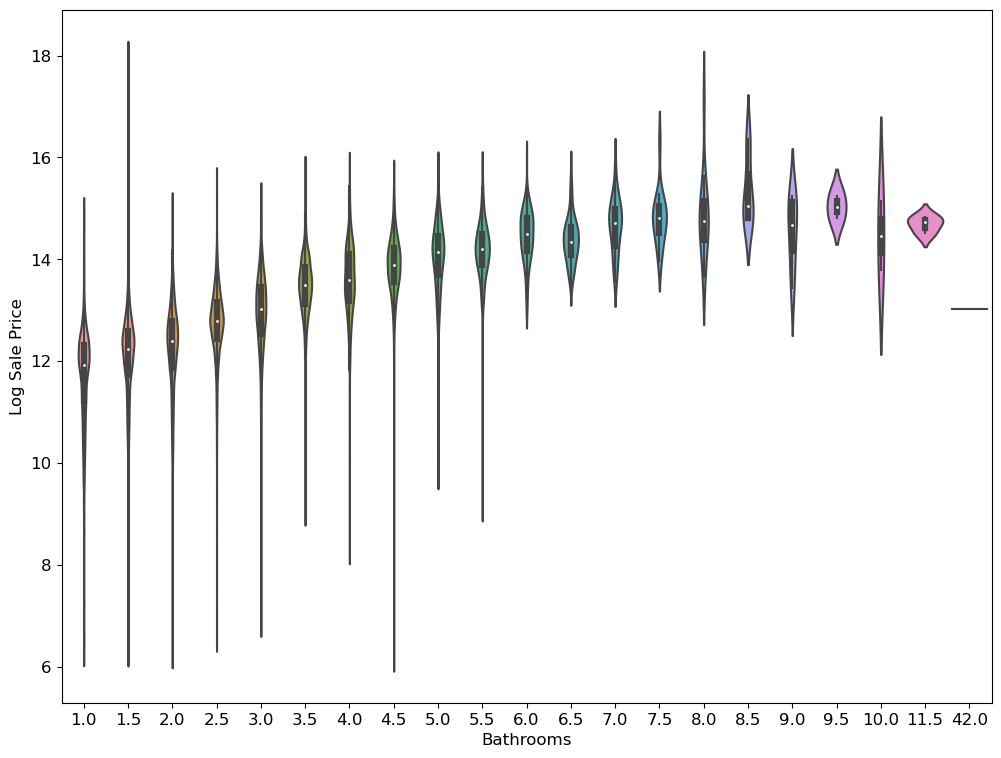

In [12]:
sns.violinplot(data=training_data, x="Bathrooms", y="Log Sale Price")

In [13]:
training_data["Road Proximity"]

1         0.0
2         0.0
3         0.0
4         1.0
6         1.0
         ... 
204787    0.0
204788    0.0
204789    0.0
204790    0.0
204791    1.0
Name: Road Proximity, Length: 168931, dtype: float64

In [14]:
training_data.groupby("Road Proximity")["Log Sale Price"].mean()

Road Proximity
0.0    12.165906
1.0    12.198759
Name: Log Sale Price, dtype: float64

In [19]:
training_data.groupby("Age")["Log Sale Price"].mean().sort_values(ascending=False)

Age
156    13.688967
4      13.578996
1      13.511379
152    13.374681
12     13.187943
         ...    
129    11.744964
157    11.741653
165    11.723434
119    11.665441
160    10.966473
Name: Log Sale Price, Length: 165, dtype: float64

In [14]:
def plot_categorical(data, variable):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x=variable,
        y='Log Sale Price',
        data=data,
        ax=axs[0],
    )

    sns.countplot(
        x=variable,
        data=data,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [26]:
top_20 = training_data["Age"].value_counts().index[:20]
in_top_20_age = training_data[training_data["Age"].isin(top_20)].copy()

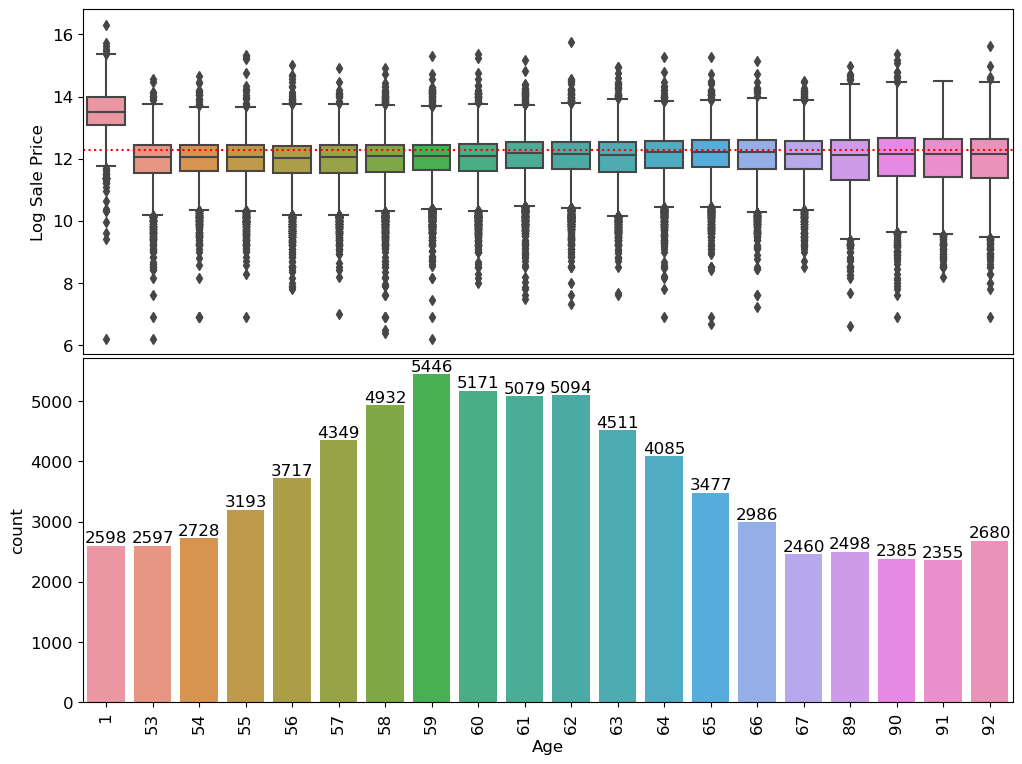

In [27]:
plot_categorical(in_top_20_age, "Age")

In [69]:
training_data["Apartments"].value_counts()

0.0    168922
5.0         7
6.0         2
Name: Apartments, dtype: int64

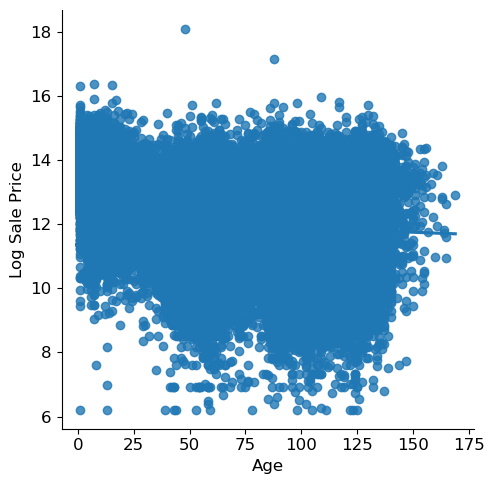

In [14]:
sns.lmplot(data=training_data, x="Age", y="Log Sale Price")

In [27]:
training_data[training_data["Age"] > 100]["Age"].value_counts()

102    1189
104     990
101     953
107     904
105     902
       ... 
158       2
159       2
160       1
169       1
157       1
Name: Age, Length: 65, dtype: int64

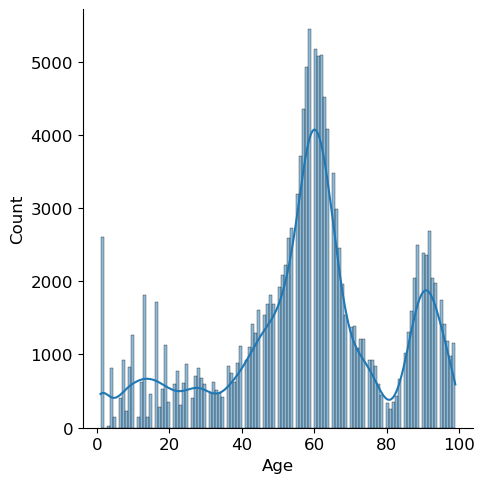

In [44]:
sns.displot(data=training_data[training_data["Age"] < 100], x="Age", kde=True)

In [51]:
training_data["Multi Code"].value_counts()

2.0    166990
3.0      1876
4.0        53
5.0         5
8.0         3
6.0         2
7.0         2
Name: Multi Code, dtype: int64

In [50]:
training_data.shape

(168931, 64)

In [73]:
training_data["Wall Material"].value_counts()

2.0    70303
1.0    59125
3.0    35717
4.0     3786
Name: Wall Material, dtype: int64

In [69]:
training_data.groupby("Garage Indicator")["Log Sale Price"].mean()

Garage Indicator
0.0    11.745142
1.0    12.225805
Name: Log Sale Price, dtype: float64

In [23]:
training_data[["Property Class"]].value_counts()

Property Class
203               77502
202               27119
278               20989
205               16094
204               10248
207                7012
206                6419
208                2487
209                1061
dtype: int64

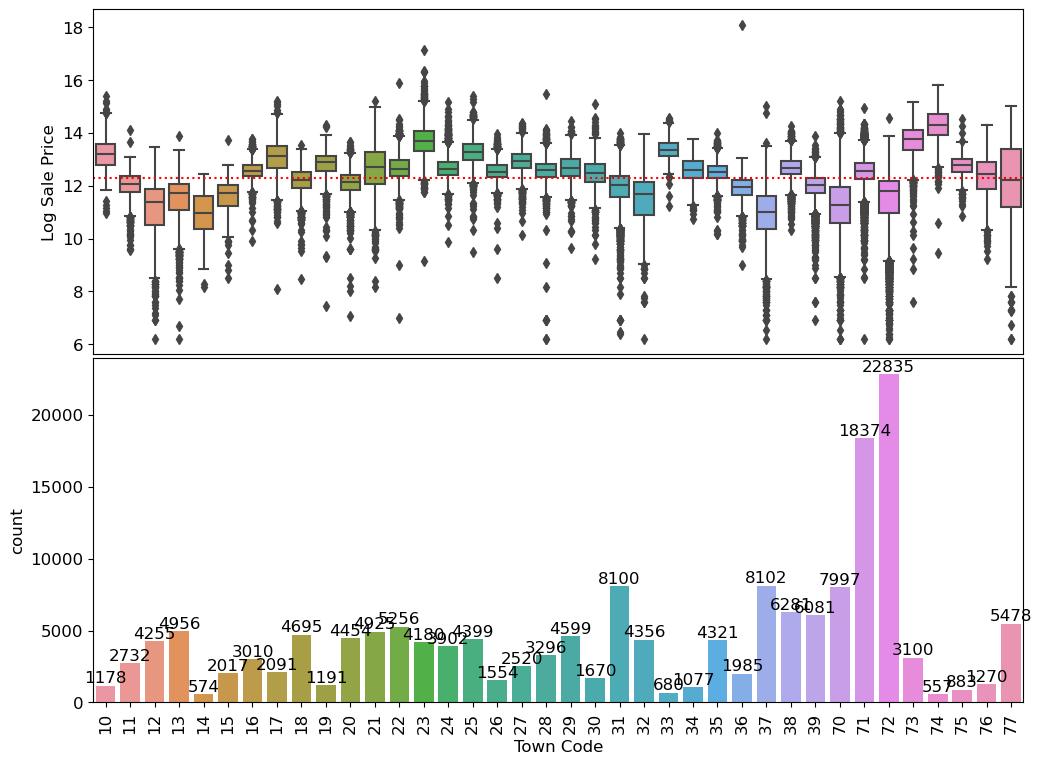

In [32]:
plot_categorical(training_data, "Town Code")

In [36]:
sum(training_data["Porch"].isnull())

168931

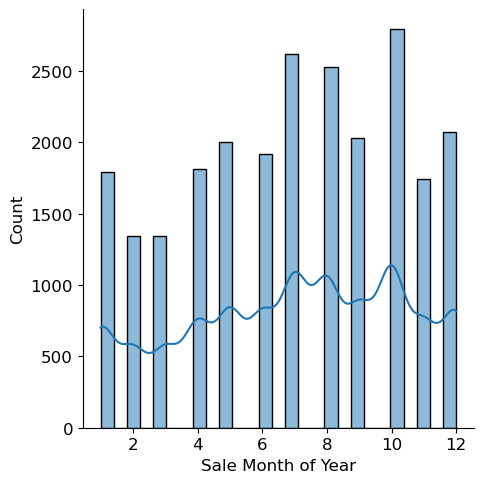

In [6]:
sns.displot(data=training_data[training_data["Sale Year"] == 2013], x="Sale Month of Year", kde=True)

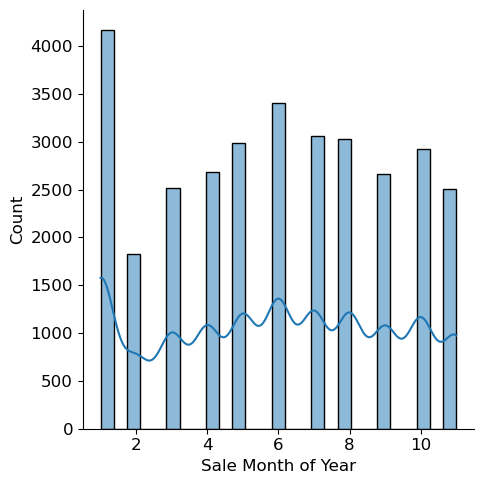

In [9]:
sns.displot(data=training_data[training_data["Sale Year"] == 2018], x="Sale Month of Year", kde=True)

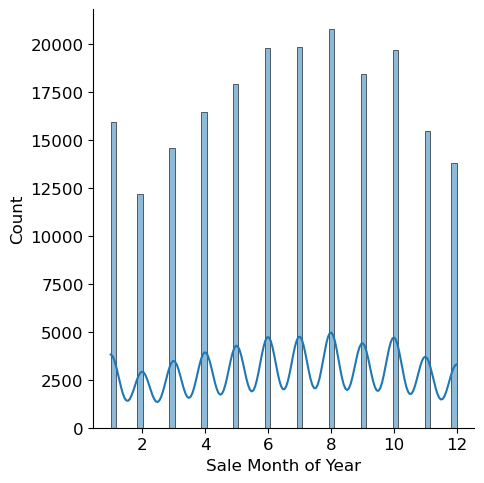

In [12]:
sns.displot(data=training_data, x="Sale Month of Year", kde=True)

In [31]:
def access_feature_importance(X, y):
    model = LinearRegression()
    model.fit(X, y)
    importance = model.coef_
    for i,v in enumerate(model.coef_):
        print('Feature: %0d, Score: %.5f' % (i,v))
    
    # plot feature importance
    pyplot.bar([x for x in range(len(importance))], importance)
    pyplot.show()

In [59]:
sum(training_data["Garage 1 Size"] == 0)

20236

In [66]:
training_data["Log Estimate (Building)"] = np.log(training_data["Estimate (Building)"])

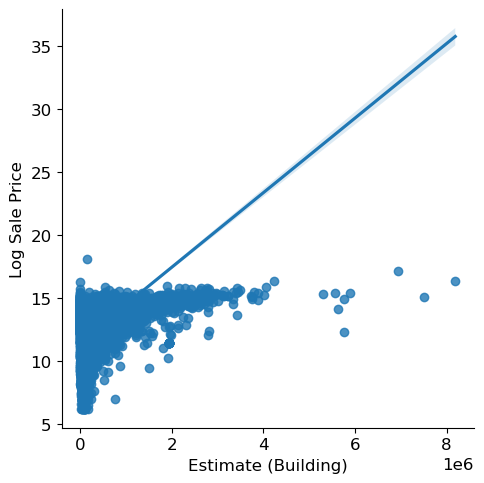

In [72]:
sns.lmplot(data=training_data, x="Estimate (Building)", y="Log Sale Price")

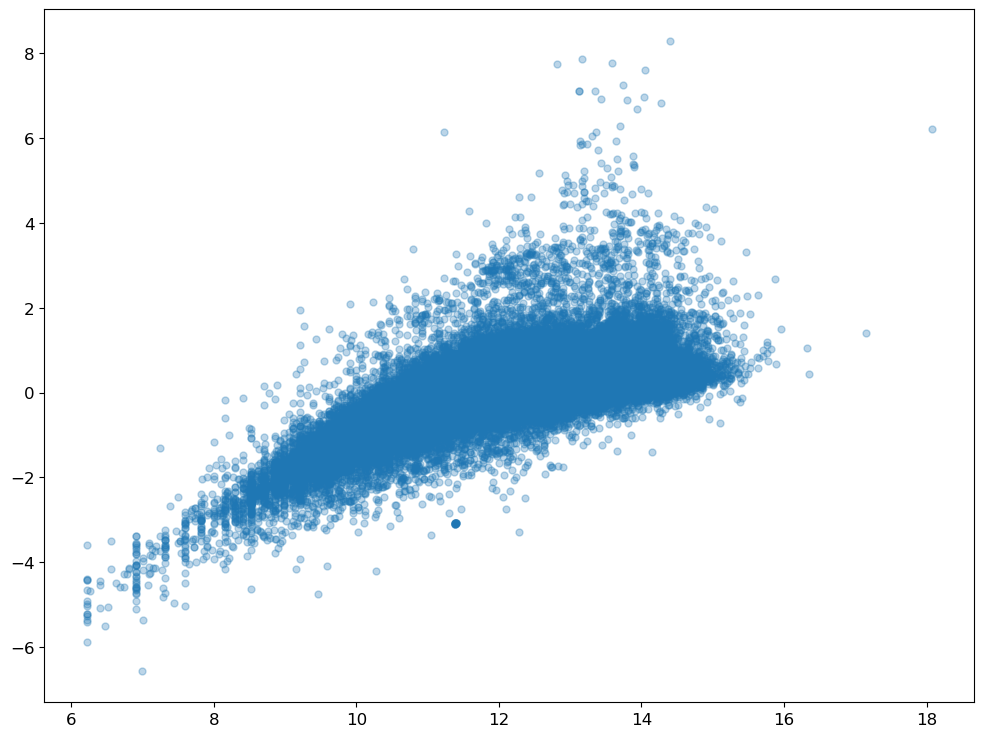

In [71]:
plt.scatter(training_data["Log Sale Price"], training_data["Log Sale Price"]-training_data["Log Estimate (Building)"],alpha=0.3, s=25)

In [75]:
training_data["Modeling Group"].value_counts()

SF    168931
Name: Modeling Group, dtype: int64

In [83]:
training_data["O'Hare Noise"].value_counts()

0.0    166193
1.0      2738
Name: O'Hare Noise, dtype: int64

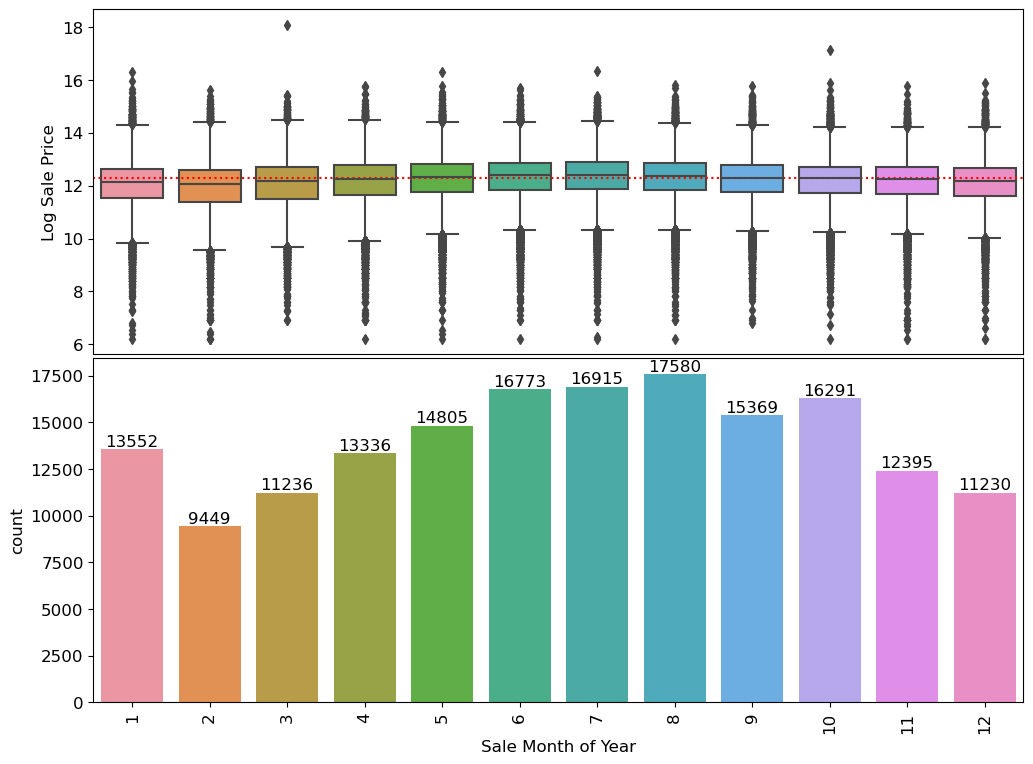

In [90]:
plot_categorical(training_data, "Sale Month of Year")

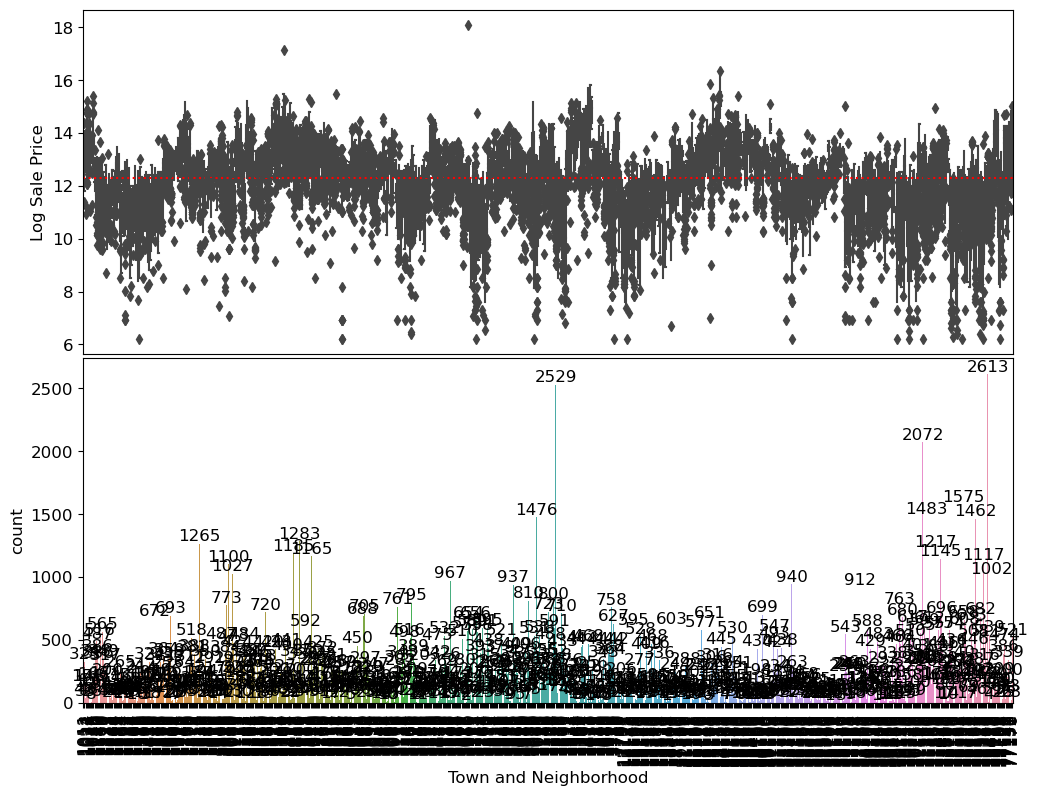

In [91]:
plot_categorical(training_data, "Town and Neighborhood")

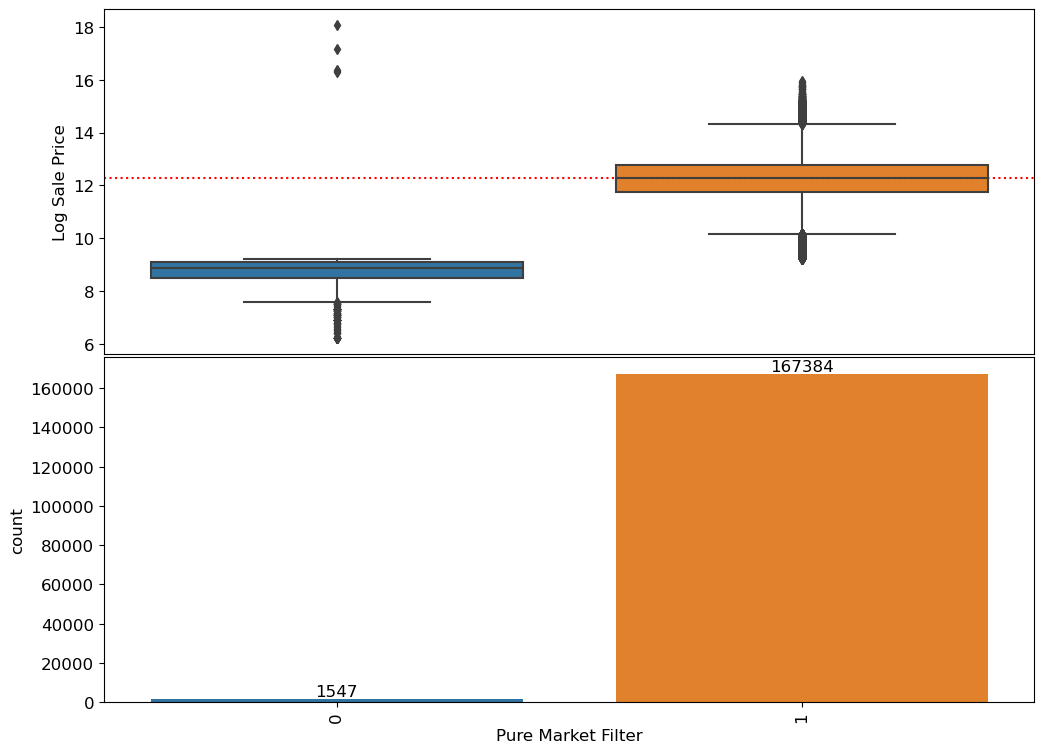

In [92]:
plot_categorical(training_data, "Pure Market Filter")